In [20]:
import pandas as pd

#reading the dataset
df = pd.read_csv("dataset_0HB-1AI.csv")
df.head()

,Unnamed: 0,sentence,class
0,0,NLP is a multidisciplinary field that draws fr...,0
1,1,"In terms of linguistics, a program must be abl...",0
2,2,Of course each language has its own forms of a...,0
3,3,Programs can use several strategies for dealin...,0
4,4,As formidable as the task of extracting the co...,0


In [21]:
# The class column represents the classification of the text in our dataset as Human (0) of AI (1)

df.shape

(7344, 3)

In [22]:
# To check for class imbalance

df['class'].value_counts()

class
1    4008
0    3336
Name: count, dtype: int64

In [23]:
df['label'] = df['class'].map({0 : "Human", 1 : "AI"})

In [24]:
df.head()

,Unnamed: 0,sentence,class,label
0,0,NLP is a multidisciplinary field that draws fr...,0,Human
1,1,"In terms of linguistics, a program must be abl...",0,Human
2,2,Of course each language has its own forms of a...,0,Human
3,3,Programs can use several strategies for dealin...,0,Human
4,4,As formidable as the task of extracting the co...,0,Human


In [25]:
# fasttext required __label__ as a prefix
df['label'] = "__label__" + df['label'].astype(str)
df.head()

,Unnamed: 0,sentence,class,label
0,0,NLP is a multidisciplinary field that draws fr...,0,__label__Human
1,1,"In terms of linguistics, a program must be abl...",0,__label__Human
2,2,Of course each language has its own forms of a...,0,__label__Human
3,3,Programs can use several strategies for dealin...,0,__label__Human
4,4,As formidable as the task of extracting the co...,0,__label__Human


In [26]:
df['label_sentence'] = df['label'] + ' ' + df['sentence']
df.head()

,Unnamed: 0,sentence,class,label,label_sentence
0,0,NLP is a multidisciplinary field that draws fr...,0,__label__Human,__label__Human NLP is a multidisciplinary fiel...
1,1,"In terms of linguistics, a program must be abl...",0,__label__Human,"__label__Human In terms of linguistics, a prog..."
2,2,Of course each language has its own forms of a...,0,__label__Human,__label__Human Of course each language has its...
3,3,Programs can use several strategies for dealin...,0,__label__Human,__label__Human Programs can use several strate...
4,4,As formidable as the task of extracting the co...,0,__label__Human,__label__Human As formidable as the task of ex...


In [27]:
#testing for regex

import re

text = "  VIKI's | Bookcase/Bookshelf (3-Shelf/Shelve, White) | ? . hi"
text = re.sub(r'[^\w\s\']',' ', text)
text = re.sub(' +', ' ', text)
text.strip().lower()

"viki's bookcase bookshelf 3 shelf shelve white hi"

In [28]:
def preprocess(text):
    text = re.sub(r'[^\w\s\']',' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip().lower() 

In [29]:
df['label_sentence'] = df['label_sentence'].map(preprocess)
df.head()

,Unnamed: 0,sentence,class,label,label_sentence
0,0,NLP is a multidisciplinary field that draws fr...,0,__label__Human,__label__human nlp is a multidisciplinary fiel...
1,1,"In terms of linguistics, a program must be abl...",0,__label__Human,__label__human in terms of linguistics a progr...
2,2,Of course each language has its own forms of a...,0,__label__Human,__label__human of course each language has its...
3,3,Programs can use several strategies for dealin...,0,__label__Human,__label__human programs can use several strate...
4,4,As formidable as the task of extracting the co...,0,__label__Human,__label__human as formidable as the task of ex...


In [30]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [31]:
train.shape, test.shape

((5875, 5), (1469, 5))

In [33]:
train.to_csv("data-ft.train", columns=["label_sentence"], index=False, header=False)
test.to_csv("data-ft.test", columns=["label_sentence"], index=False, header=False)

In [42]:
# training and testing
import fasttext

model = fasttext.train_supervised(input="data-ft.train", lr=1.0, epoch=25, wordNgrams=2)
model.test("data-ft.test")

Read 0M words
Number of words:  9829
Number of labels: 2
Progress: 100.0% words/sec/thread: 2351133 lr:  0.000000 avg.loss:  0.108969 ETA:   0h 0m 0s


(1469, 0.8311776718856365, 0.8311776718856365)

In [15]:
# First parameter (1469) is test size. 
# Second and third parameters are precision and recall respectively. 
# We are getting around 83% precision.

In [35]:
model.predict("HTTP (Hypertext Transfer Protocol) is the foundation of data communication on the World Wide Web, facilitating the transfer of information between clients (such as web browsers) and servers.")

(('__label__ai',), array([0.79388857]))

In [36]:
model.predict("HTTP means Hyper text transfer protocol")

(('__label__human',), array([0.65982616]))

              precision    recall  f1-score   support

          ai       0.82      0.88      0.85       786
       human       0.85      0.78      0.81       683

    accuracy                           0.83      1469
   macro avg       0.83      0.83      0.83      1469
weighted avg       0.83      0.83      0.83      1469



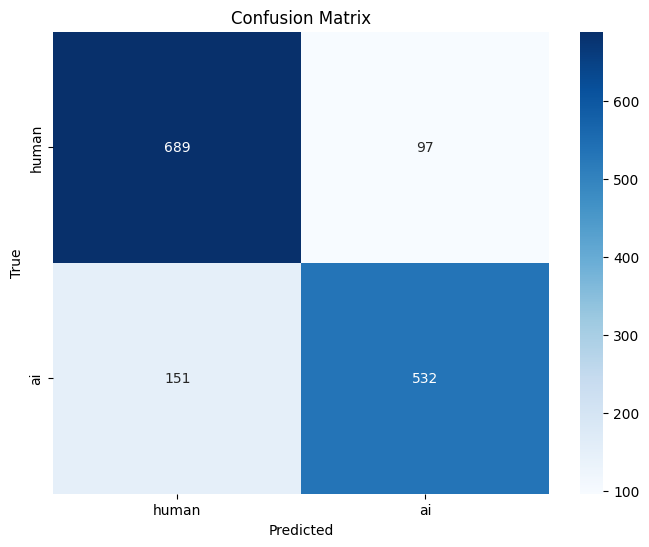

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Load test data
with open("data-ft.test", "r", encoding="utf-8") as f:
    lines = f.readlines()
    # Extracting labels and texts from the test data
    y_true = [line.split()[0].replace('__label__', '') for line in lines]
    X_test = [" ".join(line.split()[1:]) for line in lines]

# Predict using the FastText model
y_pred = [model.predict(text)[0][0].replace('__label__', '') for text in X_test]

# Generate and print the classification report
print(classification_report(y_true, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['human', 'ai'], yticklabels=['human', 'ai'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
